In [5]:
%matplotlib inline
import math
from typing import Any, cast

import d2l.d2l as d2l
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import structlog
import torch
import torchvision
from IPython.core.interactiveshell import InteractiveShell
from torch import nn
from torch.utils import data
from torchvision import transforms

logger = structlog.get_logger()

InteractiveShell.ast_node_interactivity = "all"  # type:ignore

In [1]:
10

10

# data

In [6]:
import hashlib
import os
import tarfile
import zipfile

import requests

# @save
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

cache_dir = os.path.join("..", "data")


def download(name, cache_dir: str):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f"正在从{url}下载{fname}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(
    name,
    cache_dir: str,
    folder: str | None = None,
):  # @save
    """下载并解压zip/tar文件"""
    fname = download(name, cache_dir)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        raise AssertionError("只有zip/tar文件可以被解压缩")
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def download_all():  # @save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name, cache_dir)


DATA_HUB["kaggle_house_train"] = (  # @save
    DATA_URL + "kaggle_house_pred_train.csv",
    "585e9cc93e70b39160e7921475f9bcd7d31219ce",
)

DATA_HUB["kaggle_house_test"] = (  # @save
    DATA_URL + "kaggle_house_pred_test.csv",
    "fa19780a7b011d9b009e8bff8e99922a8ee2eb90",
)

In [9]:
train_data = pd.read_csv(download("kaggle_house_train", cache_dir))
test_data = pd.read_csv(
    download(
        "kaggle_house_test",
        cache_dir,
    ),
)

In [ ]:
print(train_data.shape)
print(test_data.shape)


train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]
test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

logger.info("remove id cols, join all features")
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]])

# train_data.head()
numerical_features = all_features.dtypes[all_features.dtypes != "object"].index
all_features[numerical_features] = (
    all_features[numerical_features]
    .apply(lambda x: (x - x.mean()) / x.std())
    .fillna(0.0)
)
# one-hot encoding
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape


logger.info("convert to torch tensor")
n_train = train_data.shape[0]
train_features = torch.from_numpy(all_features[:n_train].to_numpy("float32"))
test_features = torch.from_numpy(all_features[n_train:].to_numpy("float32"))

train_labels = torch.from_numpy(
    train_data["SalePrice"].to_numpy("float32").reshape([-1, 1])
)


logger.info("train linear model")
loss = nn.MSELoss()
n_in = train_features.shape[1]


def log_rmse(net, features, labels) -> float:
    clipped_preds = torch.clamp(net(features), min=1, max=None)
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


def get_net():
    net = nn.Sequential(nn.Linear(n_in, 1))
    return net


def train(
    net,
    train_features,
    train_labels,
    test_features,
    test_labels,
    n_epoch,
    lr,
    weight_decay,
    batch_size,
):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(n_epoch):
        for X, y in train_iter:
            optimizer.zero_grad()
            _loss = loss(net(X), y)
            _loss.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


logger.info("constructed k fold cv")


def get_k_fold_data(k: int, i: int, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    X_valid, y_valid = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            assert X_train is not None
            assert y_train is not None
            X_train = torch.concat([X_train, X_part], dim=0)
            y_train = torch.concat([y_train, y_part], dim=0)
    assert X_valid is not None and y_valid is not None
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, n_epoch, lr, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        fold_data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(
            net,
            *fold_data,
            n_epoch=n_epoch,
            lr=lr,
            weight_decay=weight_decay,
            batch_size=batch_size,
        )
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(
                X=list(range(1, n_epoch + 1)),
                Y=[train_ls, valid_ls],
                xlabel="epoch",
                ylabel="rmse",
                xlim=[1, n_epoch],
                legend=["train", "valid"],
                yscale="log",
            )
        logger.info(
            "single fold loss",
            fold=i + 1,
            train_loss=f"{float(train_ls[-1])}",
            valid_loss=f"{float(valid_ls[-1])}",
        )
    return train_l_sum / k, valid_l_sum / k

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


,Id,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,2010,WD,Normal
1,1462,20,RL,81.0,2010,WD,Normal
2,1463,60,RL,74.0,2010,WD,Normal
3,1464,60,RL,78.0,2010,WD,Normal


2026-02-08 20:31:26 [info     ] remove id cols, join all features


(2919, 330)

2026-02-08 20:31:26 [info     ] convert to torch tensor       
2026-02-08 20:31:26 [info     ] train linear model            
2026-02-08 20:31:26 [info     ] constructed k fold cv         


2026-02-08 20:31:31 [info     ] output                         fold=1 train_loss=0.17036885023117065 valid_loss=0.15720994770526886
2026-02-08 20:31:33 [info     ] output                         fold=2 train_loss=0.1621885448694229 valid_loss=0.19008490443229675
2026-02-08 20:31:35 [info     ] output                         fold=3 train_loss=0.16425006091594696 valid_loss=0.16803865134716034
2026-02-08 20:31:37 [info     ] output                         fold=4 train_loss=0.16834117472171783 valid_loss=0.1549045890569687
2026-02-08 20:31:39 [info     ] output                         fold=5 train_loss=0.1632709801197052 valid_loss=0.1829734593629837
2026-02-08 20:31:39 [info     ] 5 fold cv,                     mean_train_loss=0.16568392217159272:.5f mean_valid_loss=0.17064231038093566:.5f


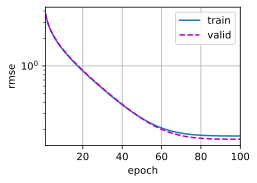

In [26]:
k, n_epoch, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(
    k=k,
    X_train=train_features,
    y_train=train_labels,
    lr=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
    n_epoch=n_epoch,
)
logger.info(
    f"{k} fold cv,", mean_train_loss=f"{train_l}:.5f", mean_valid_loss=f"{valid_l}:.5f"
)

In [29]:
def train_and_pred(
    train_features,
    test_features,
    train_labels,
    test_data,
    n_epoch,
    lr,
    weight_decay,
    batch_size,
):
    net = get_net()
    train_ls, _ = train(
        net,
        train_features=train_features,
        train_labels=train_labels,
        test_features=None,
        test_labels=None,
        n_epoch=n_epoch,
        lr=lr,
        weight_decay=weight_decay,
        batch_size=batch_size,
    )
    d2l.plot(
        X=list(range(1, n_epoch + 1)),
        Y=[train_ls],
        xlabel="epoch",
        ylabel="log rmse",
        xlim=[1, n_epoch],
        yscale="log",
    )
    logger.info("train log rmse", value=f"{train_ls[-1]}:.5f")

    predict_np = net(test_features).detach().numpy()
    test_data["SalePrice"] = pd.Series(predict_np.reshape(-1))
    submission = test_data[["Id", "SalePrice"]]
    return submission

2026-02-08 20:40:10 [info     ] train log rmse                 value=0.16265319287776947:.5f


,Id,SalePrice
0,1461,119342.148438
1,1462,154833.312500
2,1463,198624.718750
3,1464,217243.484375
4,1465,177181.453125
...,...,...
1454,2915,74564.476562
1455,2916,85763.367188
1456,2917,208844.218750
1457,2918,107120.828125


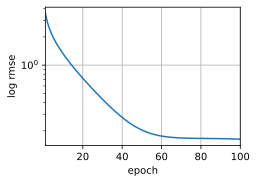

In [30]:
k, n_epoch, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_and_pred(
    train_features=train_features,
    test_features=test_features,
    train_labels=train_labels,
    test_data=test_data,
    n_epoch=n_epoch,
    lr=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
)

In [ ]:
# train_data.columns.to_list()
"Summary" in train_data

False